## **Road Sign Detection: Enhancing Model Performance with Batch Normalization and Data Augmentation**

In this notebook, we explore the critical roles of batch normalization and data augmentation in enhancing the performance of a classifier model for road sign detection, using the German Traffic Sign Recognition Benchmark (GTSRB) dataset. Our objective is to demonstrate how these techniques contribute to mitigating overfitting and achieving a well-balanced model. The exploration is structured into three distinct parts:

1. **Baseline Model Training:** We start by training a classifier model solely on the GTSRB dataset without employing batch normalization and data augmentation. This initial phase sets a baseline, allowing us to observe the model's performance and tendencies towards overfitting when these techniques are not utilized.

2. **Incorporating Batch Normalization:** Next, we modify the model to include batch normalization while still abstaining from data augmentation. This step aims to assess the impact of batch normalization on the model's ability to generalize and its overall performance, particularly in terms of accuracy and overfitting.

3. **Integrating Data Augmentation:** In the final phase, we combine both batch normalization and data augmentation into our training process. This comprehensive approach is expected to not only boost the model's accuracy but also to significantly reduce overfitting, leading to a more robust and reliable classifier for road sign detection.

Throughout these experiments, we will compare and analyze the results from each phase, drawing insights into how batch normalization and data augmentation individually and collectively contribute to the model's effectiveness in recognizing road signs.

## **Download Dataset**

In [1]:
import os
if not os.path.exists('GTSRB'):
    !pip install -U -q torch_snippets
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
    !unzip -qq GTSRB_Final_Training_Images.zip
    !unzip -qq GTSRB_Final_Test_Images.zip
    !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
    !rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip


## **Dataset Exploring**

Let's do some visualization.....

In [28]:
import matplotlib.pyplot as plt
import cv2
import os
import random
main_path = "/content/GTSRB/Final_Training/Images"

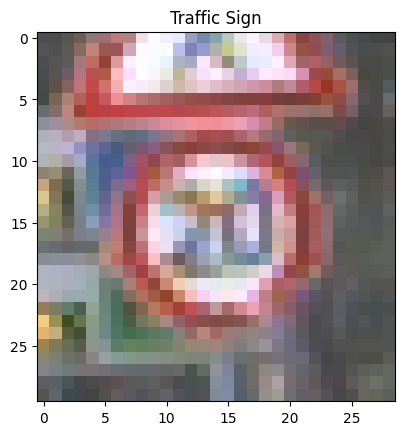

In [29]:
image_path = "/content/GTSRB/Final_Training/Images/00000/00000_00000.ppm"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
plt.imshow(image)
plt.title("Traffic Sign")
plt.show()


### Class Distribution

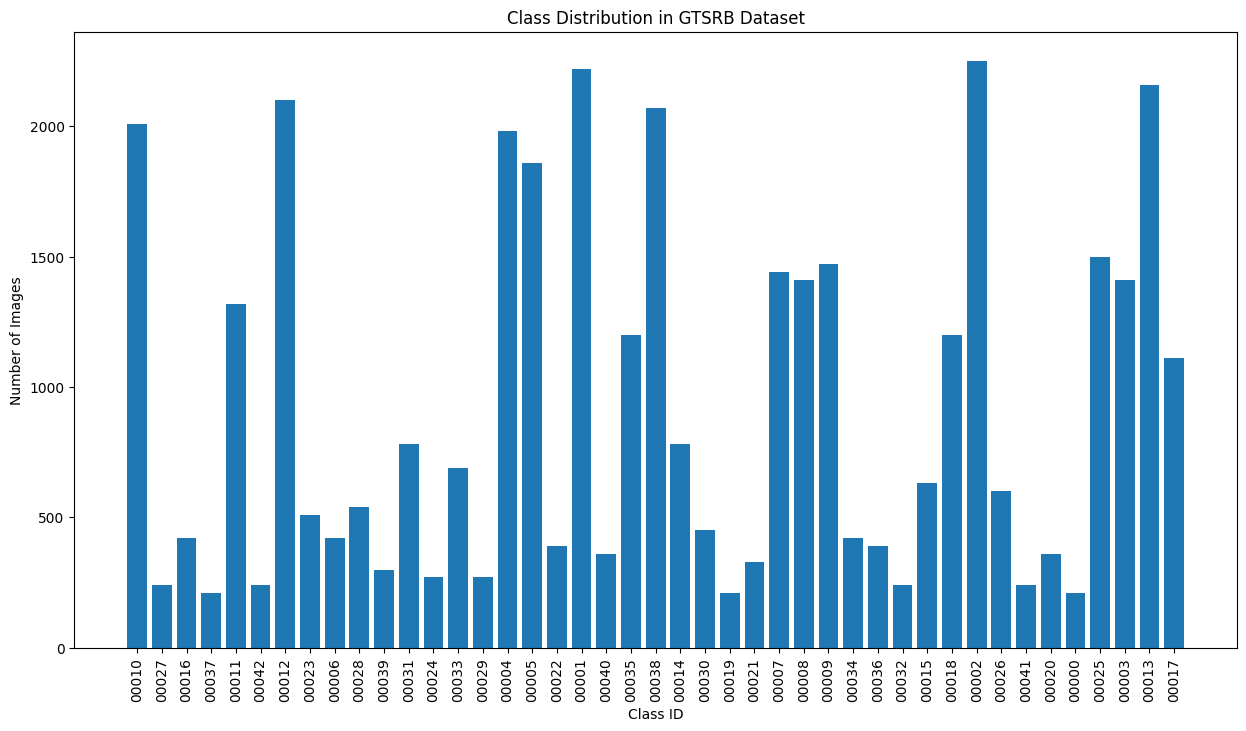

In [26]:

class_counts = {}

for folder in os.listdir(main_path):
    folder_path = os.path.join(main_path, folder)
    if os.path.isdir(folder_path):
        images = [f for f in os.listdir(folder_path) if f.endswith('.ppm')]
        class_counts[folder] = len(images)
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(15, 8))
plt.bar(classes, counts)
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Class Distribution in GTSRB Dataset')
plt.xticks(rotation=90)  # Rotate class labels for better visibility
plt.show()


### Visualizing Multiple Images

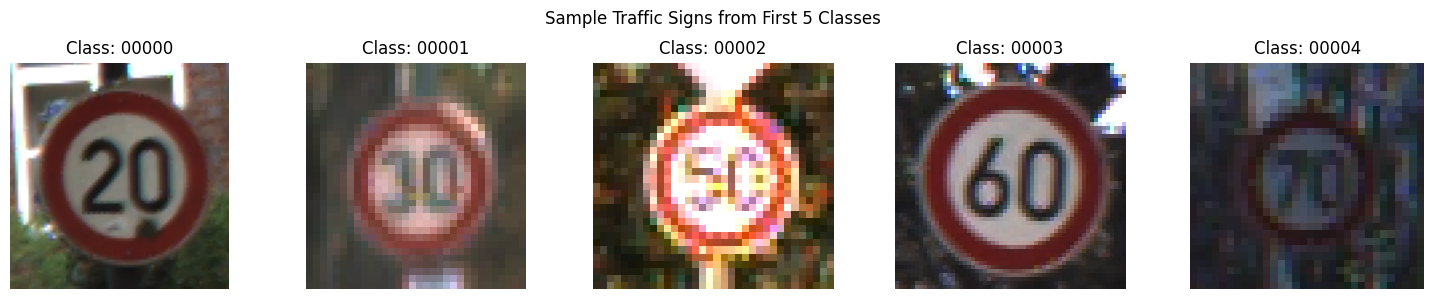

In [36]:
subfolders = [os.path.join(main_path, folder) for folder in sorted(os.listdir(main_path))[:num_classes]]

selected_images = []
for folder in subfolders:
    images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.ppm')]
    selected_images.extend(random.sample(images, 1))

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('Sample Traffic Signs from First 5 Classes')

for ax, img_path in zip(axes, selected_images):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    class_label = os.path.basename(os.path.dirname(img_path))
    ax.set_title(f"Class: {class_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## **Data Processing**

### Assign Class IDs to Possible Outcome Classes

In [2]:
from torch_snippets import *
# Importing all functions and classes from the torch_snippets module.
# This module likely contains utility functions and classes for PyTorch.

classIds = pd.read_csv('signnames.csv')
# This CSV file contains mappings of class IDs to traffic sign names.

In [3]:
classIds.set_index('ClassId', inplace=True)
# Setting the 'ClassId' column as the index of the DataFrame.
# This makes it easier to reference sign names using their ClassId.
classIds.head()

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)


In [4]:
classIds = classIds.to_dict()['SignName']
# Converting the DataFrame to a dictionary where the keys are ClassIds and
# the values are the corresponding sign names.
classIds

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vechiles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vechiles',
 16: 'Vechiles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

In [5]:
classIds = {f'{k:05d}':v for k,v in classIds.items()}
# Formatting the ClassIds as five-digit strings (padding with zeroes if necessary)
# and creating a new dictionary with these formatted keys and corresponding sign names.
classIds

{'00000': 'Speed limit (20km/h)',
 '00001': 'Speed limit (30km/h)',
 '00002': 'Speed limit (50km/h)',
 '00003': 'Speed limit (60km/h)',
 '00004': 'Speed limit (70km/h)',
 '00005': 'Speed limit (80km/h)',
 '00006': 'End of speed limit (80km/h)',
 '00007': 'Speed limit (100km/h)',
 '00008': 'Speed limit (120km/h)',
 '00009': 'No passing',
 '00010': 'No passing for vechiles over 3.5 metric tons',
 '00011': 'Right-of-way at the next intersection',
 '00012': 'Priority road',
 '00013': 'Yield',
 '00014': 'Stop',
 '00015': 'No vechiles',
 '00016': 'Vechiles over 3.5 metric tons prohibited',
 '00017': 'No entry',
 '00018': 'General caution',
 '00019': 'Dangerous curve to the left',
 '00020': 'Dangerous curve to the right',
 '00021': 'Double curve',
 '00022': 'Bumpy road',
 '00023': 'Slippery road',
 '00024': 'Road narrows on the right',
 '00025': 'Road work',
 '00026': 'Traffic signals',
 '00027': 'Pedestrians',
 '00028': 'Children crossing',
 '00029': 'Bicycles crossing',
 '00030': 'Beware of

In [6]:
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}
# Creating a new dictionary (id2int) to map sign names to a unique integer index.
# This is useful for converting categorical labels to numerical labels,
# which are often required for machine learning models.
id2int

{'Speed limit (20km/h)': 0,
 'Speed limit (30km/h)': 1,
 'Speed limit (50km/h)': 2,
 'Speed limit (60km/h)': 3,
 'Speed limit (70km/h)': 4,
 'Speed limit (80km/h)': 5,
 'End of speed limit (80km/h)': 6,
 'Speed limit (100km/h)': 7,
 'Speed limit (120km/h)': 8,
 'No passing': 9,
 'No passing for vechiles over 3.5 metric tons': 10,
 'Right-of-way at the next intersection': 11,
 'Priority road': 12,
 'Yield': 13,
 'Stop': 14,
 'No vechiles': 15,
 'Vechiles over 3.5 metric tons prohibited': 16,
 'No entry': 17,
 'General caution': 18,
 'Dangerous curve to the left': 19,
 'Dangerous curve to the right': 20,
 'Double curve': 21,
 'Bumpy road': 22,
 'Slippery road': 23,
 'Road narrows on the right': 24,
 'Road work': 25,
 'Traffic signals': 26,
 'Pedestrians': 27,
 'Children crossing': 28,
 'Bicycles crossing': 29,
 'Beware of ice/snow': 30,
 'Wild animals crossing': 31,
 'End of all speed and passing limits': 32,
 'Turn right ahead': 33,
 'Turn left ahead': 34,
 'Ahead only': 35,
 'Go straig

### Transformation Pipeline

In [7]:
from torchvision import transforms as T

"""
# Train Transformation
This transformation pipeline is essential for preparing images for a neural network, particularly in tasks like traffic sign recognition.
It ensures that all input images have the same size, are converted to tensor format, and are normalized with specific mean and standard deviation values.
The commented-out parts suggest potential data augmentation strategies that are not currently in use but can be activated if needed.

The commented part of the preceding code is to uncomment later and see the changes doe to the dataaugmentation.
"""

train_transform = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2),
    # contrast=(0.8,1.2),
    # saturation=(0.8,1.2),
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])


"""
# Validation Transformation
This pipeline is specifically designed for processing validation images. Unlike the training transformations (train_transform),
it does not include data augmentation steps like random affine transformations or color jittering, as these are generally not applied to validation data.
The aim is to evaluate the model on unaltered, standardized images to assess its performance.
"""
val_transform = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

## Custom Dataset Class

This code defines a custom dataset class, GTSRB, for handling the German Traffic Sign Recognition Benchmark (GTSRB) dataset in PyTorch. It's a subclass of Dataset, which is a fundamental building block for creating datasets in PyTorch.


In [8]:
class GTSRB(Dataset):

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

## Training & Validation Dataset
This code continues the setup for the GTSRB dataset by splitting it into training and validation sets and creating corresponding data loaders in PyTorch.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Setting the device for PyTorch operations based on the availability of CUDA (for GPU support).
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
# Retrieving all PPM image files from the specified path in the GTSRB dataset.
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

train_data = GTSRB(trn_files, transform=train_transform)
# Creating an instance of the GTSRB dataset class for training data.
# Applying the training transformations defined earlier.
val_data = GTSRB(val_files, transform=val_transform)

train_loader = DataLoader(train_data, 32, shuffle=True, collate_fn=train_data.collate_fn)
# This will batch the data, shuffle it, and apply the custom collate function for batching.
# Batch size is set to 32.
val_loader = DataLoader(val_data, 32, shuffle=False, collate_fn=val_data.collate_fn)

[11/16/23 14:03:09] INFO     29406                                                                                                 ]8;id=143726;file://<ipython-input-8-043bc6ce934f>:6\<ipython-input-8-043bc6ce934f>]8;;\:]8;id=666923;file://<ipython-input-8-043bc6ce934f>:6#__init__:6\__init__:6]8;;\

                    INFO     9803                                                                                                  ]8;id=250361;file://<ipython-input-8-043bc6ce934f>:6\<ipython-input-8-043bc6ce934f>]8;;\:]8;id=524625;file://<ipython-input-8-043bc6ce934f>:6#__init__:6\__init__:6]8;;\

## **Model without Batch Normalization & Data Augmentations**

In [10]:
import torchvision.models as models

"""
This code defines a function convBlock, which is used to create a convolutional block commonly used in convolutional neural networks (CNNs).
This block is a part of our main model architecture. Here we commented the Batch Normalization layer to see later when we uncomment this how the results changes.
"""

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        #nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

In [11]:
"""
This SignClassifier class is a complete neural network model for classifying traffic signs.
It is composed of several convolutional blocks for feature extraction, followed by fully connected layers for classification.
The forward method defines how the data flows through the network, and the compute_metrics method calculates important metrics for evaluating the model's performance.
This setup is typical for deep learning models in image classification tasks.
"""

class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc

### Train Steps

In [12]:
'''
The function train_batch is designed for training a single batch of data in a neural network using PyTorch.
It performs one step of the training process, including the forward pass, loss calculation, backpropagation, and an optimizer step.
'''
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

### Validation Steps

In [13]:
'''
This function is an essential part of the validation loop in machine learning training.
It allows you to assess the performance of your model on the validation dataset without impacting the training process.
The use of @torch.no_grad() ensures that the operation is more efficient and suitable for evaluation purposes, as it eliminates the computational overhead of tracking gradients.
'''

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

### Training the Model

In [14]:
model = SignClassifier().to(device) # Creates an instance of the 'SignClassifier' class.
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 30

Exception in thread Thread-5 (attachment_entry):

Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen

    sock, _ = endpoints_listener.accept()

  File "/usr/lib/python3.10/socket.py", line 293, in accept

    fd, addr = self._accept()

TimeoutError: timed out



During handling of the above exception, another exception occurred:



Traceback (most recent call last):

  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner

    self.run()

  File "/usr/lib/python3.10/threading.py", line 953, in run

    self._target(*self._args, **self._kwargs)

  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry

    debugpy.listen(_dap_port)

  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper

    return wrapped(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in de

EPOCH: 1.000  val_acc: 0.596  trn_acc: 0.339  val_loss: 1.243  trn_loss: 2.280  (39.26s - 1138.65s remaining)

EPOCH: 2.000  val_acc: 0.740  trn_acc: 0.691  val_loss: 0.783  trn_loss: 0.947  (64.03s - 896.49s remaining)

EPOCH: 3.000  val_acc: 0.783  trn_acc: 0.784  val_loss: 0.684  trn_loss: 0.657  (89.47s - 805.22s remaining)

EPOCH: 4.000  val_acc: 0.840  trn_acc: 0.825  val_loss: 0.498  trn_loss: 0.528  (115.14s - 748.44s remaining)

EPOCH: 5.000  val_acc: 0.849  trn_acc: 0.850  val_loss: 0.459  trn_loss: 0.460  (142.19s - 710.95s remaining)

EPOCH: 6.000  val_acc: 0.861  trn_acc: 0.864  val_loss: 0.412  trn_loss: 0.413  (166.44s - 665.78s remaining)

EPOCH: 7.000  val_acc: 0.871  trn_acc: 0.879  val_loss: 0.394  trn_loss: 0.372  (191.70s - 629.88s remaining)

EPOCH: 8.000  val_acc: 0.874  trn_acc: 0.886  val_loss: 0.397  trn_loss: 0.359  (217.46s - 598.02s remaining)

EPOCH: 9.000  val_acc: 0.881  trn_acc: 0.889  val_loss: 0.371  trn_loss: 0.343  (243.25s - 567.59s remaining)

EPO

100%|██████████| 131/131 [00:01<00:00, 74.50it/s] 


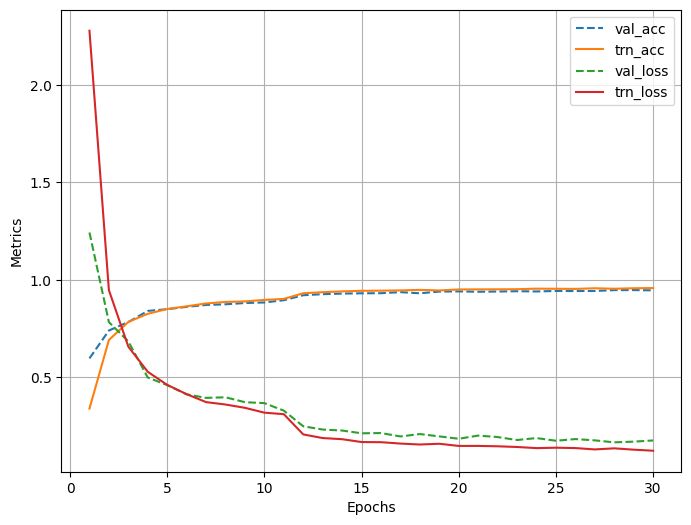

[11/16/23 14:16:19] INFO     Dumped object of size ≈1 MB @ "no-aug-no-bn.log" in 1.36e+00 seconds                         ]8;id=958917;file://<ipython-input-15-b716448d65e7>:17\<ipython-input-15-b716448d65e7>]8;;\:<cell line: 17>:17

» no-aug-no-bn.log

In [15]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_loader)
    for bx, data in enumerate(train_loader):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_loader)
    for bx, data in enumerate(val_loader):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn.log')

## **Model with Batch Normalization but without Data Augmentations**

In [16]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no), # Uncommented the Batch Normalization layer to see the changes in results due to this.
        nn.MaxPool2d(2),
    )

### Training the Model

EPOCH: 1.000  val_acc: 0.807  trn_acc: 0.590  val_loss: 0.604  trn_loss: 1.363  (25.34s - 734.87s remaining)

EPOCH: 2.000  val_acc: 0.885  trn_acc: 0.859  val_loss: 0.350  trn_loss: 0.428  (50.89s - 712.40s remaining)

EPOCH: 3.000  val_acc: 0.912  trn_acc: 0.906  val_loss: 0.268  trn_loss: 0.286  (75.43s - 678.86s remaining)

EPOCH: 4.000  val_acc: 0.910  trn_acc: 0.924  val_loss: 0.272  trn_loss: 0.231  (99.98s - 649.84s remaining)

EPOCH: 5.000  val_acc: 0.929  trn_acc: 0.936  val_loss: 0.230  trn_loss: 0.195  (125.31s - 626.54s remaining)

EPOCH: 6.000  val_acc: 0.934  trn_acc: 0.943  val_loss: 0.200  trn_loss: 0.172  (150.80s - 603.22s remaining)

EPOCH: 7.000  val_acc: 0.944  trn_acc: 0.950  val_loss: 0.179  trn_loss: 0.150  (175.75s - 577.48s remaining)

EPOCH: 8.000  val_acc: 0.949  trn_acc: 0.956  val_loss: 0.167  trn_loss: 0.128  (200.61s - 551.69s remaining)

EPOCH: 9.000  val_acc: 0.953  trn_acc: 0.961  val_loss: 0.149  trn_loss: 0.117  (226.14s - 527.67s remaining)

EPOCH

100%|██████████| 131/131 [00:03<00:00, 35.11it/s]


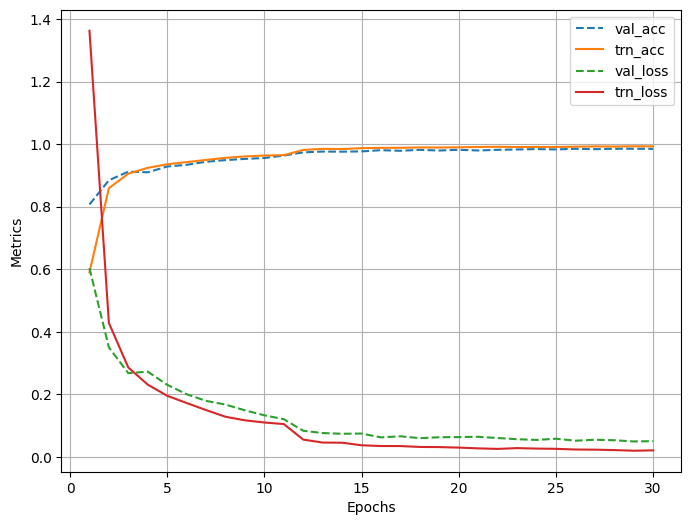

[11/16/23 14:29:06] INFO     Dumped object of size ≈1 MB @ "no-aug-yes-bn.log" in 1.40e+00 seconds                        ]8;id=10761;file://<ipython-input-17-8d0d7d307f93>:22\<ipython-input-17-8d0d7d307f93>]8;;\:<cell line: 22>:22

» no-aug-yes-bn.log

In [17]:
model = SignClassifier().to(device) # Creates an instance of the 'SignClassifier' class.
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 30

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_loader)
    for bx, data in enumerate(train_loader):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_loader)
    for bx, data in enumerate(val_loader):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-yes-bn.log')

## **Model with Batch Normalization & Data Augmentations**

In [18]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no), # Uncommented the Batch Normalization layer to see the changes in results due to this.
        nn.MaxPool2d(2),
    )

### Applying Data Augmentations

In [19]:
train_transform = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ColorJitter(brightness=(0.8,1.2),
    contrast=(0.8,1.2),
    saturation=(0.8,1.2),
    hue=0.25),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

train_data = GTSRB(trn_files, transform=train_transform)
train_loader = DataLoader(train_data, 32, shuffle=True, collate_fn=train_data.collate_fn)

                    INFO     29406                                                                                                 ]8;id=184704;file://<ipython-input-8-043bc6ce934f>:6\<ipython-input-8-043bc6ce934f>]8;;\:]8;id=60034;file://<ipython-input-8-043bc6ce934f>:6#__init__:6\__init__:6]8;;\

### Training the Model

EPOCH: 1.000  val_acc: 0.737  trn_acc: 0.449  val_loss: 0.815  trn_loss: 1.891  (47.22s - 1369.32s remaining)

EPOCH: 2.000  val_acc: 0.838  trn_acc: 0.776  val_loss: 0.495  trn_loss: 0.695  (94.36s - 1321.04s remaining)

EPOCH: 3.000  val_acc: 0.870  trn_acc: 0.838  val_loss: 0.395  trn_loss: 0.498  (143.15s - 1288.31s remaining)

EPOCH: 4.000  val_acc: 0.887  trn_acc: 0.866  val_loss: 0.349  trn_loss: 0.400  (190.81s - 1240.28s remaining)

EPOCH: 5.000  val_acc: 0.903  trn_acc: 0.891  val_loss: 0.288  trn_loss: 0.335  (239.36s - 1196.78s remaining)

EPOCH: 6.000  val_acc: 0.920  trn_acc: 0.902  val_loss: 0.246  trn_loss: 0.298  (289.16s - 1156.64s remaining)

EPOCH: 7.000  val_acc: 0.929  trn_acc: 0.914  val_loss: 0.213  trn_loss: 0.262  (337.76s - 1109.77s remaining)

EPOCH: 8.000  val_acc: 0.927  trn_acc: 0.918  val_loss: 0.216  trn_loss: 0.242  (387.21s - 1064.82s remaining)

EPOCH: 9.000  val_acc: 0.925  trn_acc: 0.926  val_loss: 0.231  trn_loss: 0.225  (435.51s - 1016.19s remain

100%|██████████| 131/131 [00:01<00:00, 67.09it/s]


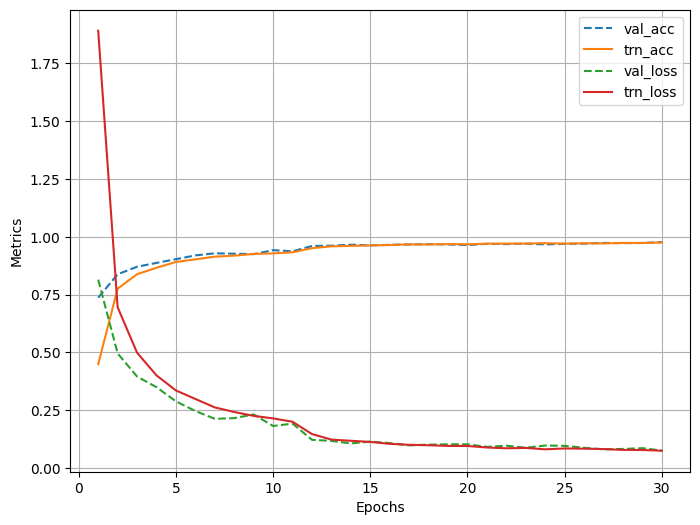

[11/16/23 14:54:48] INFO     Dumped object of size ≈1 MB @ "yes-aug-yes-bn.log" in 1.43e+00 seconds                       ]8;id=194560;file://<ipython-input-20-530ded37a2ef>:22\<ipython-input-20-530ded37a2ef>]8;;\:<cell line: 22>:22

» yes-aug-yes-bn.log

In [20]:
model = SignClassifier().to(device) # Creates an instance of the 'SignClassifier' class.
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 30

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_loader)
    for bx, data in enumerate(train_loader):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_loader)
    for bx, data in enumerate(val_loader):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'yes-aug-yes-bn.log')

## **Summary of Experimental Observations**

Our experimentation with the model yielded insightful findings:

1. **Model Performance without Batch Normalization:** We observed that the model's accuracy was notably lower in the absence of batch normalization. This suggests the importance of batch normalization in enhancing the model's ability to generalize.

2. **Model Performance with Batch Normalization but without Data Augmentations:** When batch normalization was included without accompanying data augmentations, there was a significant increase in accuracy. However, this configuration led to overfitting, as evidenced by the model performing exceptionally well on the training data but not as well on unseen data.

3. **Model Performance with Both Batch Normalization and Data Augmentations:** The incorporation of both batch normalization and data augmentations resulted in the most balanced model. This setup not only achieved high accuracy but also demonstrated minimal overfitting. This conclusion is supported by the close resemblance between training and validation loss values, indicating a well-generalized model.

That's all for today! Hope you enjoyed it!

------------------
At the end, I would like to thanks the author of the book named "[Modern Computer Vision with PyTorch](https://www.amazon.com/Modern-Computer-Vision-PyTorch-applications/dp/1839213477)" for including and explaining this topic. I hope it helped poeple on Kaggle.

## **Learn More**
Here are a few more fundamental topics I tried to cover.

- **[Mastering PyTorch Tensors: Fundamentals to Advance](https://www.kaggle.com/code/tanvirnwu/mastering-pytorch-tensors-fundamentals-to-advance)**
- **[Linear Regression](https://www.kaggle.com/code/tanvirnwu/linear-regression)**
- **[Saving and Loading PyTorch Models: A Comprehensive](https://www.kaggle.com/code/tanvirnwu/saving-and-loading-pytorch-models-a-comprehensive)**
- **[Comprehensive Guide on NumPy for Beginners](https://www.kaggle.com/code/tanvirnwu/comprehensive-guide-on-numpy-for-beginners#Learn-More)**
- **[Dictionary in Python with Examples & Explanations](https://www.kaggle.com/code/tanvirnwu/dictionary-in-python-with-examples-explanations)**
- **[List in Python for Beginners](https://www.kaggle.com/code/tanvirnwu/list-in-python-for-beginners)**
- **[A Brief Introduction of Graph Neural Network (GNN): Concepts, Types, and Uses](https://www.kaggle.com/discussions/general/449125#2493256)**
- **[Essential Python Libraries for Data Visualization](https://www.kaggle.com/discussions/getting-started/450857)**

### **Thank you!!**